# Plots
Cascade Tuholske Aug 2021

Make plots of dist binned population from GHCN/GSOD stations 

In [1]:
import os
import rasterio
from rasterio import features
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point 
import matplotlib.pyplot as plt
import numpy as np

### Turn CHIRTS-daily GHCN/GSOD stations into points

In [2]:
# Open Stations
stations_fn = os.path.join('/Users/cpt2136/Github/UrbanHeat/data/CHIRTS-daily/ValidationData/Validated/GHCN-and-GSOD-CHIRTSTmax_ERA5_meta-with-validation.csv')
stations = pd.read_csv(stations_fn)
stations.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)

# Turn into gdf
stations['geometry'] = [Point(xy) for xy in zip(stations['longitudes'], stations['latitudes'])] # creating a geometry column 
crs = {'init': 'epsg:4326'} # Coordinate reference system : WGS84
stations_gdf = gpd.GeoDataFrame(stations, crs=crs)

# get geom 
stations_pnt = gpd.GeoDataFrame(stations_gdf['geometry'])

/Users/cpt2136/miniconda3/envs/geo38/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Burn Arrays

In [99]:
def buffer_burn(gdf_in, buff, buff_dist = None, touch = False):
    
    """ Takes points or polys, buffers them and burns them into an array, all touched is set to False by defualt. 
    Returns burned array.
    Args:
        gdf_in = points to buffer
        buff = if True, then buffer a point
        buff_dist = distance to buffer, in degrees
        touch = all touch or no touch burn, see rasterio documentation
    """
    
    # buffer polys
    if buff == True:
        buffer = gpd.GeoDataFrame(geometry = gdf_in.buffer(buff_dist))
        buffer['ID'] = 1
    
    else:
        buffer = gdf_in
    
    # Burn array
    ghs_fn = os.path.join('/Users/cpt2136/Github/PopGridCompare/data/interim/GHS15_matched.tif') 
    ghs = rasterio.open(ghs_fn) # base map

    meta = ghs.meta.copy() # copy meta data from rst
    arr = ghs.read(1) # get an array to burn shapes
    arr.fill(0) # revalue rst to an Nan Value before burning in polygons 

    # extract geom and values to burn
    shapes = ((geom,value) for geom, value in zip(buffer['geometry'], buffer['ID'])) 

    # burn shapes into an array - Using no touch see rasterstats zonal stats documentation for justification 
    burned = features.rasterize(shapes=shapes, fill=0, out=arr, transform=ghs.transform, all_touched=touch)
    
    return burned

In [4]:
# buff 1k, 5k, 10k, 25k - error is ok, we're using unprojected data and this a-OK for this project
buff_1k = buffer_burn(points_in = stations_pnt, buff_dist = 0.01, touch = False)
buff_5k = buffer_burn(points_in = stations_pnt, buff_dist = 0.05, touch = False)
buff_10k = buffer_burn(points_in = stations_pnt, buff_dist = 0.1, touch = False)
buff_25k = buffer_burn(points_in = stations_pnt, buff_dist = 0.25, touch = False)

<ipython-input-3-505a9c03b915>:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = gpd.GeoDataFrame(geometry = points_in.buffer(buff_dist))


In [5]:
# buff differences
buff_1_5k = buff_1k + buff_5k
buff_1_5k[buff_1_5k > 1] = 0

buff_5_10k = buff_5k + buff_10k
buff_5_10k[buff_5_10k == 2] = 0

buff_10_25k = buff_10k + buff_25k
buff_10_25k[buff_10_25k == 2] = 0 

In [6]:
# > 25 K
buff_25k_plus = buff_25k.copy()

# invert so 1 is all area >25k from station
buff_25k_plus[buff_25k_plus == 1] = 2
buff_25k_plus[buff_25k_plus == 0] = 1
buff_25k_plus[buff_25k_plus == 2] = 0

In [ ]:
# save out buffers - update arr_out and out_fn 
# ghs_fn = os.path.join('/Users/cpt2136/Github/PopGridCompare/data/interim/GHS15_matched.tif') 
# ghs = rasterio.open(ghs_fn) # base map

# meta = ghs.meta.copy() # copy meta data from rst
# arr = ghs.read(1) # get an array to burn shapes

# # name them 
# arr_out = buff_25k_plus
# out_fn = os.path.join('../data/interim/GHCN-GSOD-25k-plus.tif')

# # write the raster
# with rasterio.open(out_fn, 'w', **meta) as out:
#     out.write_band(1, arr_out)

### Total

In [17]:
def tot_pop(arr):
    tot = (arr * ghs_arr).sum()
    
    return tot

In [45]:
# get populations
ghs_fn = os.path.join('/Users/cpt2136/Github/PopGridCompare/data/interim/GHS15_matched.tif') 
ghs_arr = rasterio.open(ghs_fn).read(1)

In [46]:
# remove nan -999 values from ghs pop
ghs_arr[ghs_arr < 1] = 0

In [20]:
# Gut check
all_1k = (buff_1k * ghs_arr).sum() / 10**6
print('all 1-k',(buff_1k * ghs_arr).sum() / 10**6) 
urban_1k = (urban_1k * ghs_arr).sum() / 10**6
print('urban 1-k', (urban_1k * ghs_arr).sum() / 10**6)
peri_1k = (peri_1k * ghs_arr).sum() / 10**6
print('peri 1-k',(peri_1k * ghs_arr).sum() / 10**6)

all 1-k 38.830341638166324
urban 1-k 239833.89617297243
peri 1-k 22252.63970698611


In [51]:
# totals 
tot_1k = (buff_1k * ghs_arr).sum()
tot_1_5k = (buff_1_5k * ghs_arr).sum()
tot_5_10k = (buff_5_10k * ghs_arr).sum()
tot_10_25k = (buff_10_25k * ghs_arr).sum()
tot_25k_plus = (buff_25k_plus * ghs_arr).sum()

In [52]:
# list 
totals = [tot_1k, tot_1_5k, tot_5_10k, tot_10_25k, tot_25k_plus]

In [53]:
totals

[38830341.63816632,
 597281954.6628637,
 808711345.9065161,
 1359450883.0836291,
 4539033735.996844]

In [54]:
# World population
print('world', ghs_arr.sum() /10**9)
print('totals',sum(totals) /10**9)

world 7.343308261288027
totals 7.343308261288019


### Urban Totals

In [55]:
smod_fn = os.path.join('../data/interim/GHS-SMOD15-Urban-Peri-Rural-Matched.tif')
smod_urban = rasterio.open(smod_fn).read(1)

In [56]:
# smod -200 = NaN, 10 = Water, 111 = Rural, 222 = Peri Urban and towns, 333 = Urban
urban = smod_urban.copy()
urban[urban == -200] = 0 # set nan to zero
urban[urban == 111] = 0 # set rural to zero 
urban[urban == 222] = 0 # set peri urban to zero
urban[urban == 333] = 1 # set urban to 1
print(np.unique(urban))

[0 1]


In [57]:
np.count_nonzero(urban == 1)

1384501

In [58]:
np.count_nonzero(smod_urban == 333)

1384501

In [60]:
# make urban arrays
tot_urban_1k = (buff_1k * urban * ghs_arr).sum()
tot_urban_1_5k = (buff_1_5k * urban * ghs_arr).sum()
tot_urban_5_10k = (buff_5_10k * urban * ghs_arr).sum()
tot_urban_10_25k = (buff_10_25k * urban * ghs_arr).sum()
tot_urban_25k_plus = (buff_25k_plus * urban * ghs_arr).sum()

In [61]:
# list
urban_totals = [tot_urban_1k, tot_urban_1_5k, tot_urban_5_10k, tot_urban_10_25k, tot_urban_25k_plus] 

In [62]:
# World population
print('world urban', (ghs_arr * urban).sum() /10**9)
print('urban totals', sum(urban_totals) /10**9)

world urban 4.505177582944893
urban totals 4.505177582944939


### Peri-Urban and Town Arrays

In [63]:
smod_fn = os.path.join('../data/interim/GHS-SMOD15-Urban-Peri-Rural-Matched.tif')
smod_peri = rasterio.open(smod_fn).read(1)

In [64]:
# smod -200 = NaN, 10 = Water, 111 = Rural, 222 = Peri peri and towns, 333 = peri
peri = smod_peri.copy()
peri[peri == -200] = 0 # set nan to zero 
peri[peri == 111] = 0 # set rural to zero 
peri[peri == 333] = 0 # set urban to zero
peri[peri == 222] = 1 # set peri to 1
print(np.unique(peri))

[0 1]


In [65]:
np.count_nonzero(peri == 1)

1416736

In [14]:
np.count_nonzero(smod_peri == 222)

1416736

In [69]:
# make peri arrays
tot_peri_1k = (buff_1k * peri * ghs_arr).sum()
tot_peri_1_5k = (buff_1_5k * peri * ghs_arr).sum()
tot_peri_5_10k = (buff_5_10k * peri * ghs_arr).sum()
tot_peri_10_25k = (buff_10_25k * peri * ghs_arr).sum()
tot_peri_25k_plus = (buff_25k_plus * peri * ghs_arr).sum()

In [70]:
# list
peri_totals = [tot_peri_1k, tot_peri_1_5k, tot_peri_5_10k, tot_peri_10_25k, tot_peri_25k_plus] 

In [71]:
# World population
print('world peri', (ghs_arr * peri).sum() /10**9)
print('peri totals', sum(peri_totals) /10**9)

world peri 0.8148320237761467
peri totals 0.8148320237761422


### Plot

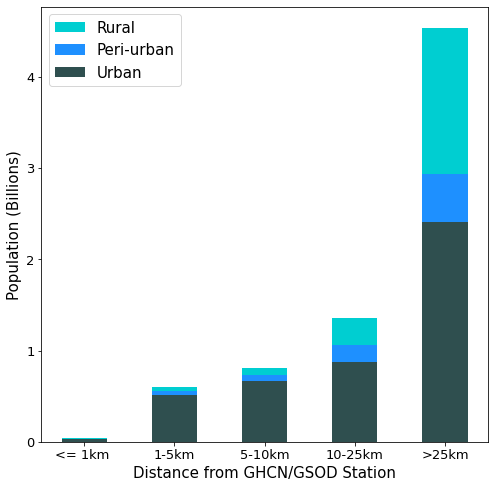

In [108]:
# Make bar plot 
fn_out = os.path.join('../data/figs/Fig1.tif')

fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**6

locs = [1,2,3,4,5]

# All
data = totals
data = [x / 10**9 for x in data]
plt.bar(locs, data, color = 'darkturquoise', width=0.5)

# peri-urban 
data = [a + b for a, b in zip(urban_totals, peri_totals)]
data = [x / 10**9 for x in data]
plt.bar(locs, data, color = 'dodgerblue', width=0.5)

# Urban 
data = urban_totals
data = [x / 10**9 for x in data]
plt.bar(locs, data, color = 'darkslategray', width=0.5)

# Labels & ticks
labels = ['<= 1km ', '1-5km', '5-10km', '10-25km', '>25km'];
plt.xticks([1,2,3,4,5], labels, fontsize = 13);
plt.xlabel('Distance from GHCN/GSOD Station', fontsize = 15)
plt.ylabel('Population (Billions)', fontsize = 15)
plt.yticks(fontsize = 13);

# legend
leg = ['Rural', 'Peri-urban', 'Urban']
plt.legend(leg, fontsize = 15)

plt.savefig(fn_out, dpi = 300, bbox_inches='tight') # tif

### India, USA, Brazil, Nigeria

In [103]:
def get_totals(in_arr):
    
    " Subsets totals with an array "
    
    # totals 
    sub_tot_1k = (buff_1k * ghs_arr * in_arr).sum()
    sub_tot_1_5k = (buff_1_5k * ghs_arr * in_arr).sum()
    sub_tot_5_10k = (buff_5_10k * ghs_arr * in_arr).sum()
    sub_tot_10_25k = (buff_10_25k * ghs_arr).sum()
    sub_tot_25k_plus = (buff_25k_plus * ghs_arr * in_arr).sum()
    print('totals done')
    
    # make urban arrays
    sub_tot_urban_1k = (buff_1k * urban * ghs_arr * in_arr).sum()
    sub_tot_urban_1_5k = (buff_1_5k * urban * ghs_arr * in_arr).sum()
    sub_tot_urban_5_10k = (buff_5_10k * urban * ghs_arr * in_arr).sum()
    sub_tot_urban_10_25k = (buff_10_25k * urban * ghs_arr * in_arr).sum()
    sub_tot_urban_25k_plus = (buff_25k_plus * urban * ghs_arr * in_arr).sum()
    print('urbaan done')
    
    # make peri arrays
    sub_tot_peri_1k = (buff_1k * peri * ghs_arr * in_arr).sum()
    sub_tot_peri_1_5k = (buff_1_5k * peri * ghs_arr * in_arr).sum()
    sub_tot_peri_5_10k = (buff_5_10k * peri * ghs_arr * in_arr).sum()
    sub_tot_peri_10_25k = (buff_10_25k * peri * ghs_arr * in_arr).sum()
    sub_tot_peri_25k_plus = (buff_25k_plus * peri * ghs_arr * in_arr).sum()
    
     # lists
    sub_totals = [sub_tot_1k, sub_tot_1_5k, sub_tot_5_10k, sub_tot_10_25k, sub_tot_25k_plus]
    sub_urban_totals = [sub_tot_urban_1k, sub_tot_urban_1_5k, sub_tot_urban_5_10k, sub_tot_urban_10_25k, sub_tot_urban_25k_plus] 
    sub_peri_totals = [sub_tot_peri_1k, sub_tot_peri_1_5k, sub_tot_peri_5_10k, sub_tot_peri_10_25k, sub_tot_peri_25k_plus] 
    
    return sub_totals, sub_urban_totals, sub_peri_totals

In [97]:
# Open shape file - China
shapes_fn = os.path.join('../../GeoClim/data/raw/shapefiles/gadm36_CHN_shp/gadm36_CHN_0.shp')
shapes = gpd.read_file(shapes_fn)
polys = gpd.GeoDataFrame(shapes['geometry'])
polys['ID'] = 1

# Burn it
rst = buffer_burn(polys, buff = False, buff_dist = None, touch = True)

# make it for country
chn_tot, chn_urban, chn_per = get_totals(in_arr = rst)

In [100]:
# Burn it
rst = buffer_burn(polys, buff = False, buff_dist = None, touch = True)

In [104]:
# make it for country
chn_tot, chn_urban, chn_per = get_totals(in_arr = rst)

In [107]:
sum(chn_tot) /10 ** 9

2.5254706036338557

# Final plot

In [ ]:
#### Make Figure and save it -- CHIRTS CORRELATION
#FN_OUT = 'FIG-WBGT32-S1'

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 4)

# All
f_ax1 = fig.add_subplot(gs[:, 0:2])



















# Legend
labels = ['PGF', 'CHIRTS-daily']
plt.legend(labels, fontsize = 16)

# Africa
f_ax2 = fig.add_subplot(gs[0, 2])
region = 'Northern America'
data = urban[urban['sub-region'] == region]
f_ax2.hist(data['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax2.hist(data['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax2.set_xlim(xlim)
f_ax2.set_title('Northern America', fontsize = 16)

# S Asia 
f_ax3 = fig.add_subplot(gs[1, 2])
region = 'Southern Asia'
data = urban[urban['sub-region'] == region]
f_ax3.hist(data['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax3.hist(data['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax3.set_xlim(xlim)
f_ax3.set_title('Southern Asia', fontsize = 16)

# Africa
f_ax4 = fig.add_subplot(gs[0, 3])
region = 'Africa'
data = urban[urban['region'] == region]
f_ax4.hist(data['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax4.hist(data['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax4.set_xlim(xlim)
f_ax4.set_title('Africa', fontsize = 16)

# Western Asia
f_ax5 = fig.add_subplot(gs[1, 3])
region = 'Western Asia'
data = urban[urban['sub-region'] == region]
f_ax5.hist(data['Princeton_cor'], color = 'mediumblue', alpha = 0.2)
f_ax5.hist(data['CHIRTS_cor'], color = 'springgreen', alpha = 0.6)
f_ax5.set_xlim(xlim)
f_ax5.set_title('Western Asia', fontsize = 16)

# save it out
#plt.savefig(FIG_OUT+FN_OUT+'.tiff', dpi = 300, bbox_inches='tight') # tif
#plt.savefig(FIG_OUT+FN_OUT+'.png', dpi = 300, bbox_inches='tight') # png